# <a id='toc1_'></a>[Analysis of June 15th 2022 Flight at 1 Hz](#toc0_)

Goal: 
1. Import the data one time
2. Plot in modifiable windows
3. Do basic analysis with static mask
4. Show results in pretty plots



## <a id='toc1_1_'></a>[Table of Contents](#toc0_)
* Importing 1 Hz Data
* Manual index masking method (1 Hz)
    * Descent mask
    * Cruising mask
* Main Analysis
    * $P_{required}$ Reduction
        * $\eta$ Steady [cl_finders.eta_steady]
        * $ C_T $ Steady [cl_finders.thrust_steady]
        * Descending [cf_finders.desc2preq]
    * $C_D$ Reduction
        * Turning power to drag coefficient [cl_finders.preq2cd]
    * CL Reduction
        * Bank angle compensated [cl_finders.cl_banked]
* Descending drag polar production
    * $C_L$, $C_D$ averaging
        * Plotting raw polar data w. errorbars
    * Curve fitting polar [cl_finders.cd2polar]
    * Standardized $P_{required}$ [cl_finders.polar2preqew]
* Cruising drag polar production
    * $C_L$, $C_D$ averaging



**Table of contents**<a id='toc0_'></a>    
- [Analysis of June 15th 2022 Flight at 1 Hz](#toc1_)    
  - [Table of Contents](#toc1_1_)    
  - [Importing packages \& Libraries](#toc1_2_)    
  - [Importing data at 1 Hz](#toc1_3_)    
  - [Defining Vehicle Parameters](#toc1_4_)    
  - [Manually defining 1 Hz Mask](#toc1_5_)    
  - [Main Analysis: $P_{req}$, $C_D$, $C_L$ Datapoints](#toc1_6_)    
  - [Descending Drag Polar Production](#toc1_7_)    
    - [Averaging $C_D$, $C_L$, Plotting](#toc1_7_1_)    
    - [Curve fitting polar [cl_finders.cd2polar]](#toc1_7_2_)    
    - [Standardized $P_{required}$ [cl_finders.polar2preqew]](#toc1_7_3_)    
  - [Cruising Drag Polar Production](#toc1_8_)    
    - [Averaging $C_D$, $C_L$, Plotting](#toc1_8_1_)    
    - [New function, collecting all CL, CD and running averages](#toc1_8_2_)    
    - [Curve fitting Polar [cl_finders.cd2polar]](#toc1_8_3_)    
    - [Standardized $P_{req}$](#toc1_8_4_)    
  - [Results Summary (Cruising \& Descending)](#toc1_9_)    
    - [Getting Angle of Attack vs $C_L$ Correlation](#toc1_9_1_)    
    - [Exporting Aerodynamic model of Vehicle](#toc1_9_2_)    
    - [Plotting $P_{req}$ vs. EAS Raw and Fitted Results](#toc1_9_3_)    
    - [Plotting C_L vs C_D, Descending and Cruising Results](#toc1_9_4_)    
  - [Time Indexed Plots](#toc1_10_)    
    - [Plotting Time Indexed data - Demanded vs True Airspeed \& Motor RPM](#toc1_10_1_)    
    - [Plotting motor RPM over the selected time intervals](#toc1_10_2_)    
    - [Plotting J to see where data needs exclusion](#toc1_10_3_)    
    - [Plotting System Efficiency](#toc1_10_4_)    
    - [Plotting Descent Rates, Zero RPM highlighted](#toc1_10_5_)    
    - [Pitch and Coefficient of Lift Time Plots](#toc1_10_6_)    
  - [Exporting All Results](#toc1_11_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
### Definining name of analysis ###
name = '2022-07-01_CREATeV_2022-06-15_Analysis_1Hz'
data_path = '../../data/'
data_folder = 'createv-2022-06-15'
file_name = 'june15_2022.BIN'
datasave_path = data_path+data_folder+'/'
result_path = '../Results/'+name+'/'
figure_path = '../Figures/'+name+'/'

## <a id='toc1_2_'></a>[Importing packages \& Libraries](#toc0_)

In [2]:
from os import sys
import os
sys.path.append('../../')

%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.io

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

### Creating Folders for Results/Data ###
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

# Setting Plot Defaults
plt.style.use('../../basic_plotter.mplstyle')

## <a id='toc1_3_'></a>[Importing data at 1 Hz](#toc0_)

In [3]:
# Importing data, specifying import characteristics, backing up results
rate = "1s"
interpolateM = "linear"
processor = "CREATeV_2022"

rawdata_name = data_folder+'/'+file_name.split('.')[0]+'_'+rate+'_'+interpolateM+'_'+processor+'.pkl'

# Checking if the data is already pickled for analysis
if os.path.exists(data_path+rawdata_name):
    df = pd.read_pickle(data_path+rawdata_name)
else:
    df = main.get_data(processor, data_folder+'/'+file_name, rate)
    df = df.interpolate(method=interpolateM)
    pd.to_pickle(df, data_path+rawdata_name) # Storing parsed data

# Becoming function in main.py (data_load)

In [4]:
# Relegated, replaced with the code block above
# Importing data from BIN files #

#df = main.get_data("Alton", "june15_2022.BIN", "10ms")
#df = main.get_data("Alton", "june15_2022.BIN", "1s")

## Pickling that DF for Later ##

#df.to_pickle("./data/june15_2022.pkl")

## Unpickling 
# df_100Hz = pd.read_pickle("../data/createv-2022-06-15/june15_2022_100Hz.pkl")
# df_60Hz = pd.read_pickle("../data/createv-2022-06-15/june15_2022_60Hz.pkl")
# df_1Hz = pd.read_pickle("../data/createv-2022-06-15/june15_2022_1Hz.pkl")

# df = df_1Hz.interpolate(method="linear")

## <a id='toc1_4_'></a>[Defining Vehicle Parameters](#toc0_)

In [5]:
# Vehicle parameters
prop = propellers.aeronaut185x12() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.727 # Estimated with virtual bolt included
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

P_systems = 4 # Amount of power consumed by everything except the ESC & motor

## <a id='toc1_5_'></a>[Manually defining 1 Hz Mask](#toc0_)

In [6]:
### Mask Initialization ###

mask = np.array([[9000, 9574],
                [9600, 10200],
                [10200,10900],
                [10900,11500],
                [11500,11900],
                [12800,13049],
                [13057,13350],
                [13400,13950],
                [14050,14450]])

desc_mask = np.array([[3449 , 3497],
                    [3687 , 3744],
                    [3931 , 3991],
                    [4166 , 4231],
                    [4419 , 4487],
                    [4653 , 4737],
                    [4915 , 4988],
                    [5159 , 5236],
                    [5395 , 5476],
                    [5648 , 5741],
                    [5922 , 6007],
                    [6194 , 6279],
                    [6462 , 6550],
                    [6743 , 6841],
                    [7039 , 7149],
                    [7347 , 7458],
                    [7672 , 7770],
                    [7980 , 8078],
                    [8302 , 8423],
                    [8586 , 8690]])

## <a id='toc1_6_'></a>[Main Analysis: $P_{req}$, $C_D$, $C_L$ Datapoints](#toc0_)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_6867/2104576070.py:25: RuntimeWarning: divide by zero encountered in true_divide
  J = v_tas / (n * prop.diameter)
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_6867/2104576070.py:25: RuntimeWarning: invalid value encountered in true_divide
  J = v_tas / (n * prop.diameter)
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/Performance_Investigations/../../propellers.py:113: RuntimeWarning: invalid value encountered in add
  CT = -1.636*J**5 + 3.933*J**4 - 3.246*J**3 + 0.8995*J**2 - 0.09467*J**1 + 0.08651 # (11-18 Fit, Freewheel data)
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/Performance_Investigations/../../propellers.py:121: RuntimeWarning: invalid value encountered in subtract
  CP = 0.2741*J**4 - 0.5853*J**3 + 0.3012*J**2 - 0.05987*J**1 + 0.04802 # (11-18 Fit, Freewheel data)
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations

Freewheel thrust coefficient:  -0.00804445463199624 
 Advance Ratio:  0.8386905840958647 
 CP Freewheel:  5.129680916149404e-10


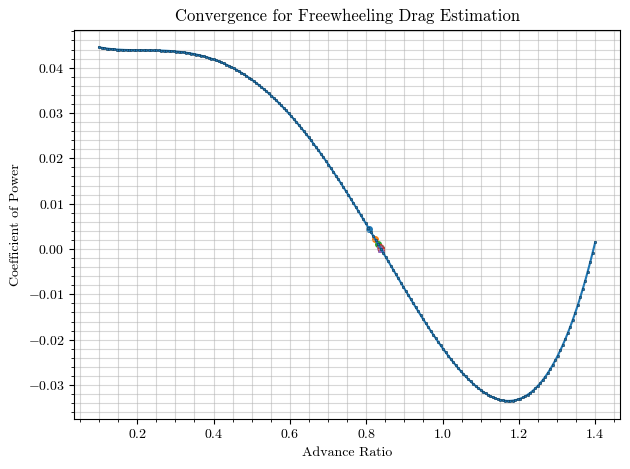

Propeller Drag[nan  0.  0. ...  0.  0.  0.]


/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/Performance_Investigations/../../cl_finders.py:219: RuntimeWarning: divide by zero encountered in reciprocal
  CD = p_required * (q * v * aircraft.area)**-1
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/Performance_Investigations/../../cl_finders.py:219: RuntimeWarning: invalid value encountered in multiply
  CD = p_required * (q * v * aircraft.area)**-1
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/Performance_Investigations/../../cl_finders.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  CL = aircraft.weight * (np.cos(phi) * q * aircraft.area)**-1


In [7]:
############# Main Analysis ###############3

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians
pitch = np.deg2rad(df["PitchAngle"].to_numpy())         # Pitch angle in radians

# Atmospheric adjustments:
rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df["Altitude_POS"].to_numpy()                   # Altitude
Vd_eas = df["DescendingXK"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed

# Ground speed limiter
v_dem = df["Airspeed_Demanded"].to_numpy()

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df["EscCurrent"].to_numpy()
v_esc = df["EscVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Estimated propulsive power (New Fitting)
P_eta = cl_finders.eta_steady(prop, motor, v_tas, n, i_esc, v_esc)
P_ct = cl_finders.thrust_steady(prop, rho, v_tas, n)
P_desc = cl_finders.desc2preq(createv, prop, rho, v_tas, n, q, Vd_tas)

# Getting drag coefficient
Cd_eta = cl_finders.preq2cd(createv, v_tas, q, P_eta)
Cd_ct = cl_finders.preq2cd(createv, v_tas, q, P_ct)
Cd_desc = cl_finders.preq2cd(createv, v_tas, q, P_desc)

# Getting lift coefficient
CL = cl_finders.cl_banked(createv, q, phi)

## <a id='toc1_7_'></a>[Descending Drag Polar Production](#toc0_)
### <a id='toc1_7_1_'></a>[Averaging $C_D$, $C_L$, Plotting](#toc0_)

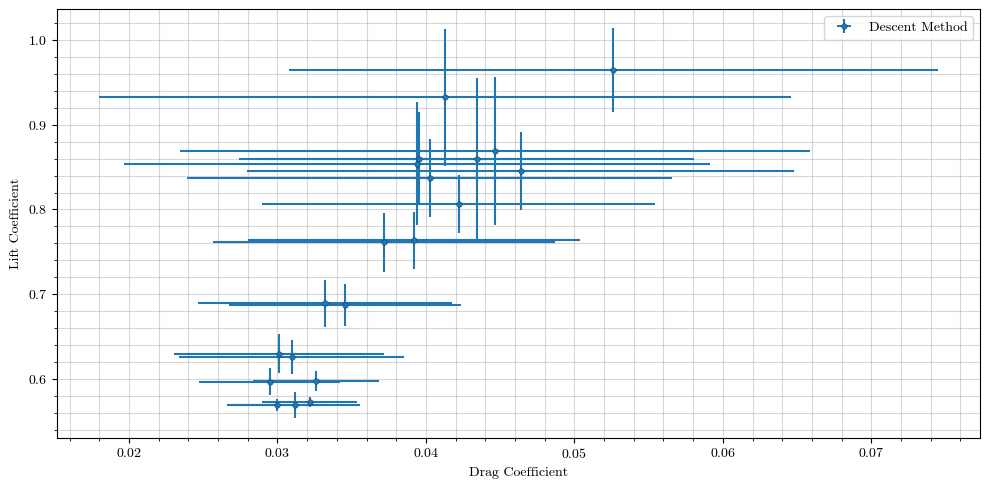

In [8]:
# Descending drag polar production
CDdesc_ave = np.zeros(len(desc_mask))
CLdesc_ave = np.zeros(len(desc_mask))
CDdesc_std = np.zeros(len(desc_mask))
CLdesc_std = np.zeros(len(desc_mask))

EASdesc_ave = np.zeros(len(desc_mask))

for i in range(len(desc_mask)):
    CDdesc_ave[i] = np.mean(Cd_desc[int(desc_mask[i,0]):int(desc_mask[i,1])])
    CLdesc_ave[i] = np.mean(CL[int(desc_mask[i,0]):int(desc_mask[i,1])])
    EASdesc_ave[i] = np.mean(v_eas[int(desc_mask[i,0]):int(desc_mask[i,1])])

    CDdesc_std[i] = np.std(Cd_desc[int(desc_mask[i,0]):int(desc_mask[i,1])])
    CLdesc_std[i] = np.std(CL[int(desc_mask[i,0]):int(desc_mask[i,1])])

plt.figure(figsize=(10,5))
plt.errorbar(CDdesc_ave, CLdesc_ave, xerr=CDdesc_std, yerr=CLdesc_std, fmt='o', label="Descent Method")
plt.xlabel("Drag Coefficient")
plt.ylabel("Lift Coefficient")
plt.legend()
plt.grid(True)
plt.show()

### <a id='toc1_7_2_'></a>[Curve fitting polar [cl_finders.cd2polar]](#toc0_) [&#8593;](#toc0_)

In [9]:
polar_desc = cl_finders.cd2polar(createv, CDdesc_ave, CLdesc_ave)
polar_desc

array([0.02021189, 0.6603808 ])

### <a id='toc1_7_3_'></a>[Standardized $P_{required}$ [cl_finders.polar2preqew]](#toc0_) [&#8593;](#toc0_)

In [10]:
Peq_desc, EAS = cl_finders.polar2preqew(createv, polar_desc, (7,14))

## <a id='toc1_8_'></a>[Cruising Drag Polar Production](#toc0_)

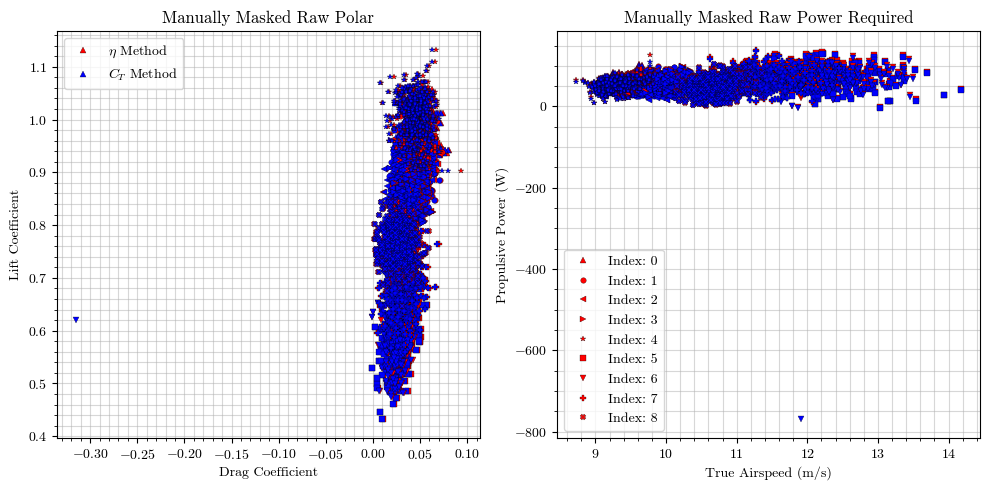

Plot already exists


In [11]:
# Plotting Raw Polar Results + Raw Power Results

rawpolar_rawpower = plt.figure(figsize=(10,5))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(1,2,2)

ax0.set_title("Manually Masked Raw Polar")
markers = ['^', 'o', '<', '>', '*', 's', 'v', 'P', 'X', 'D', 'H']
for i in range(len(mask)):
    ax0.plot(Cd_eta[int(mask[i,0]):int(mask[i,1])], CL[int(mask[i,0]):int(mask[i,1])], linestyle='', marker=markers[i], markerfacecolor='r', markersize=4, markeredgecolor=[0,0,0])
    ax0.plot(Cd_ct[int(mask[i,0]):int(mask[i,1])], CL[int(mask[i,0]):int(mask[i,1])], linestyle='', marker=markers[i], markerfacecolor='b', markersize=4, markeredgecolor=[0,0,0])
ax0.set_ylabel("Lift Coefficient")
ax0.set_xlabel("Drag Coefficient")
ax0.legend(['$\eta$ Method', '$C_T$ Method'])

ax1.set_title("Manually Masked Raw Power Required")
for i in range(len(mask)):
    ax1.plot(v_tas[int(mask[i,0]):int(mask[i,1])], P_eta[int(mask[i,0]):int(mask[i,1])], label="Index: "+str(i), linestyle='', marker=markers[i], markerfacecolor='r', markersize=4, markeredgecolor=[0,0,0])
    ax1.plot(v_tas[int(mask[i,0]):int(mask[i,1])], P_ct[int(mask[i,0]):int(mask[i,1])], linestyle='', marker=markers[i], markerfacecolor='b', markersize=4, markeredgecolor=[0,0,0])
ax1.set_xlabel("True Airspeed (m/s)")
ax1.set_ylabel("Propulsive Power (W)")
ax1.legend()
plt.show()

main.save_figure(rawpolar_rawpower, f'{rawpolar_rawpower=}'.split('=')[0], figure_path)

### <a id='toc1_8_1_'></a>[Averaging $C_D$, $C_L$, Plotting](#toc0_)

In [12]:
# Cruising averaging
CDct_ave = np.zeros(len(mask))
CDeta_ave = np.zeros(len(mask))

CL_ave = np.zeros(len(mask))
EAS_ave = np.zeros(len(mask))

pitch_ave = np.zeros(len(mask))

CDct_std = np.zeros(len(mask))
CDeta_std = np.zeros(len(mask))
CL_std = np.zeros(len(mask))

for i in range(len(mask)):
    
    CDeta_ave[i] = np.mean(Cd_eta[int(mask[i,0]):int(mask[i,1])])
    CDct_ave[i] = np.mean(Cd_ct[int(mask[i,0]):int(mask[i,1])])
    CL_ave[i] = np.mean(CL[int(mask[i,0]):int(mask[i,1])])
    EAS_ave[i] = np.mean(v_eas[int(mask[i,0]):int(mask[i,1])])
    pitch_ave[i] = np.mean(pitch[int(mask[i,0]):int(mask[i,1])])
    
    CDeta_std[i] = np.std(Cd_eta[int(mask[i,0]):int(mask[i,1])])
    CDct_std[i] = np.std(Cd_ct[int(mask[i,0]):int(mask[i,1])])
    CL_std[i] = np.std(CL[int(mask[i,0]):int(mask[i,1])])

### Same as above but functionalized

In [13]:
# Cruising and Descending Averaging

[cl_seg_means_ct, cl_seg_stds_ct, cl_seg_ci95s_ct, cd_seg_means_ct, cd_seg_stds_ct, cd_seg_ci95s_ct] = cl_finders.collect_segments(mask, CL, Cd_ct)
[cl_seg_means_eta, cl_seg_stds_eta, cl_seg_ci95s_eta, cd_seg_means_eta, cd_seg_stds_eta, cd_seg_ci95s_eta] = cl_finders.collect_segments(mask, CL, Cd_eta)

[cl_seg_means_desc, cl_seg_stds_desc, cl_seg_ci95s_desc, cd_seg_means_desc, cd_seg_stds_desc, cd_seg_ci95s_desc] = cl_finders.collect_segments(mask, CL, Cd_desc)

### <a id='toc1_8_2_'></a>[New function, collecting all CL, CD and running averages](#toc0_)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_6867/1578076385.py:24: RuntimeWarning: Mean of empty slice.
  cl_means_cruise = [cl_total_cruise[digitized_cruise == i].mean() for i in range(1, len(bins))]
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_6867/1578076385.py:25: RuntimeWarning: Mean of empty slice.
  cl_means_desc = [cl_total_desc[digitized_desc == i].mean() for i in range(1, len(bins))]
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_6867/1578076385.py:27: RuntimeWarning: Mean of empty slice.
  cd_means_eta = [cd_total_eta[digitized_cruise == i].mean() for i in range(1, len(bins))]
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_6867/1578076385.py:28: RuntimeWarning: Mean of empty slice.
  cd_means_ct = [cd_total_ct[digiti

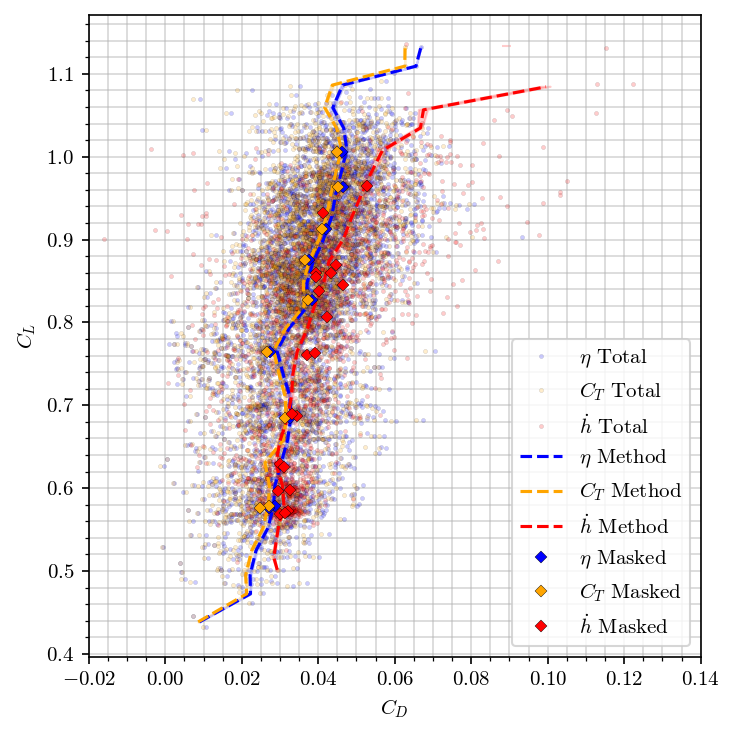

In [14]:
# Collecting all CL, CD data points for cruising, plotting with better visuals

def collect_segments(variable, mask_array):
    total = np.array([])
    for i in range(len(mask_array)):
        total = np.append(total, variable[mask_array[i,0]:mask_array[i,1]])
    return total

# Cruise drag data
cd_total_eta = collect_segments(Cd_eta, mask)
cd_total_ct = collect_segments(Cd_ct, mask)
# Cruise lift data
cl_total_cruise = collect_segments(CL, mask)
# Descending lift/drag data
cd_total_desc = collect_segments(Cd_desc, desc_mask)
cl_total_desc = collect_segments(CL, desc_mask)

# Binning averages
bins = np.linspace(0.05, 1.4, 51)
digitized_cruise = np.digitize(cl_total_cruise, bins)
digitized_desc = np.digitize(cl_total_desc, bins)

# Lift binning/averaging
cl_means_cruise = [cl_total_cruise[digitized_cruise == i].mean() for i in range(1, len(bins))]
cl_means_desc = [cl_total_desc[digitized_desc == i].mean() for i in range(1, len(bins))]
# Drag averaging
cd_means_eta = [cd_total_eta[digitized_cruise == i].mean() for i in range(1, len(bins))]
cd_means_ct = [cd_total_ct[digitized_cruise == i].mean() for i in range(1, len(bins))]
cd_means_desc = [cd_total_desc[digitized_desc == i].mean() for i in range(1, len(bins))]

# Lift standard deviation
cl_stds_cruise = [cl_total_cruise[digitized_cruise == i].std() for i in range(1, len(bins))]
cl_stds_desc = [cl_total_desc[digitized_desc == i].std() for i in range(1, len(bins))]
# Drag standard deviation
cd_stds_eta = [cd_total_eta[digitized_cruise == i].std() for i in range(1, len(bins))]
cd_stds_ct = [cd_total_ct[digitized_cruise == i].std() for i in range(1, len(bins))]
cd_stds_desc = [cd_total_desc[digitized_desc == i].std() for i in range(1, len(bins))]

# Calculation of confidence intervals
#cd_ci95_desc[i] = 1.96 * cd_stds_eta * (np.sqrt(len(Cd_ct[masks[i]])) **-1)
cd_ci95_desc = [ 1.96 * (np.sqrt(len(digitized_desc == i)))**-1 * cd_total_desc[digitized_desc == i].std() for i in range(1, len(bins)) ]
cd_ci95_eta = [ 1.96 * (np.sqrt(len(digitized_cruise == i)))**-1 * cd_total_eta[digitized_cruise == i].std() for i in range(1, len(bins)) ]
cd_ci95_ct = [ 1.96 * (np.sqrt(len(digitized_cruise == i)))**-1 * cd_total_ct[digitized_cruise == i].std() for i in range(1, len(bins)) ]

cl_ci95_cruise = [ 1.96 * (np.sqrt(len(digitized_cruise == i)))**-1 * cl_total_cruise[digitized_cruise == i].std() for i in range(1, len(bins)) ]
cl_ci95_desc = [ 1.96 * (np.sqrt(len(digitized_desc == i)))**-1 * cl_total_desc[digitized_desc == i].std() for i in range(1, len(bins)) ]

raw_ave_polarw_confint = plt.figure(figsize=(5,5), dpi=150)
plt.plot(cd_total_eta, cl_total_cruise, linestyle='', marker='.', color = 'blue', alpha = 0.2, label='$\eta$ Total')
plt.plot(cd_total_ct, cl_total_cruise, linestyle='', marker='.', color='orange', alpha = 0.2, label='$C_T$ Total')
plt.plot(cd_total_desc, cl_total_desc, linestyle='', marker='.', color ='red', alpha = 0.2, label='$\dot{h}$ Total')
plt.plot(cd_means_eta, cl_means_cruise, linestyle='--', color='blue', marker='', label='$\eta$ Method')
plt.plot(cd_means_ct, cl_means_cruise, linestyle='--', color='orange', marker='', label='$C_T$ Method')
plt.plot(cd_means_desc, cl_means_desc, linestyle='--', color='red', marker='', label='$\dot{h}$ Method')
plt.fill_betweenx(cl_means_cruise, np.array(cd_means_eta) - np.array(cd_ci95_eta), np.array(cd_means_eta) + np.array(cd_ci95_eta), color='blue', alpha=0.2)
plt.fill_betweenx(cl_means_cruise, np.array(cd_means_ct) - np.array(cd_ci95_ct), np.array(cd_means_ct) + np.array(cd_ci95_ct), color='orange', alpha=0.2)
plt.fill_betweenx(cl_means_desc, np.array(cd_means_desc) - np.array(cd_ci95_desc), np.array(cd_means_desc) + np.array(cd_ci95_desc), color='red', alpha=0.2)
# Plotting manually masked and averaged data points
plt.plot(CDeta_ave, CL_ave, linestyle='', marker='D', color = 'blue', label='$\eta$ Masked')
plt.plot(CDct_ave, CL_ave, linestyle='', marker='D', color='orange', label='$C_T$ Masked')
plt.plot(CDdesc_ave, CLdesc_ave, linestyle='', marker='D', color ='red', label='$\dot{h}$ Masked')

plt.legend()
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.xlim([-0.02, 0.14])
plt.show()

main.save_figure(raw_ave_polarw_confint, f'{raw_ave_polarw_confint=}'.split('=')[0], figure_path, overwrite=True)

### <a id='toc1_8_3_'></a>[Curve fitting Polar [cl_finders.cd2polar]](#toc0_) [&#8593;](#toc0_)

In [15]:
# Finding drag polar:
polar_eta = cl_finders.cd2polar(createv, CDeta_ave, CL_ave)
polar_ct = cl_finders.cd2polar(createv, CDct_ave, CL_ave)

### <a id='toc1_8_4_'></a>[Standardized $P_{req}$](#toc0_)

In [16]:
# Finding power required @ SSL @ Standard weight of 12.6 kg
Peq_eta, EAS = cl_finders.polar2preqew(createv, polar_eta, (8,14))
Peq_ct, EAS = cl_finders.polar2preqew(createv, polar_ct, (8,14))

## <a id='toc1_9_'></a>[Results Summary (Cruising \& Descending)](#toc0_)

### <a id='toc1_9_1_'></a>[Getting Angle of Attack vs $C_L$ Correlation](#toc0_)

In [17]:
# Finding AOA correlation to Coefficient of Lift:
CL_alpha = cl_finders.angleModel(CL_ave, pitch_ave, "linear")

### <a id='toc1_9_2_'></a>[Exporting Aerodynamic model of Vehicle](#toc0_)

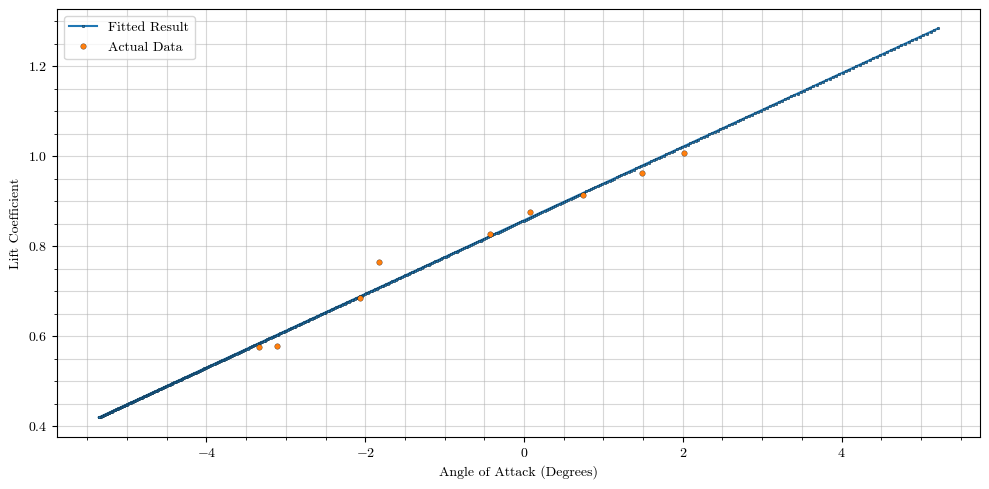

Plot already exists


In [18]:
# Exporting aerodynamic model of vehicle (C_T)
EAS_model, CL_model, CD_model, AoA_model = cl_finders.basicModel(createv, polar_ct, CL_alpha, (8,14))
export = np.transpose(np.vstack((EAS_model, CD_model, CL_model, AoA_model)))
tmp =  {'data': export}
scipy.io.savemat(result_path+'simpleModel.mat', {'data': export})

cl_alpha_fitting = plt.figure(figsize=(10,5))
plt.plot(AoA_model, CL_model, label='Fitted Result')
plt.plot(np.rad2deg(pitch_ave), CL_ave, linestyle='None', marker='o', label='Actual Data')
plt.legend()
plt.xlabel("Angle of Attack (Degrees)")
plt.ylabel("Lift Coefficient")
plt.grid(True)
plt.show()

main.save_figure(cl_alpha_fitting, f'{cl_alpha_fitting=}'.split('=')[0], figure_path)

### <a id='toc1_9_3_'></a>[Plotting $P_{req}$ vs. EAS Raw and Fitted Results](#toc0_)

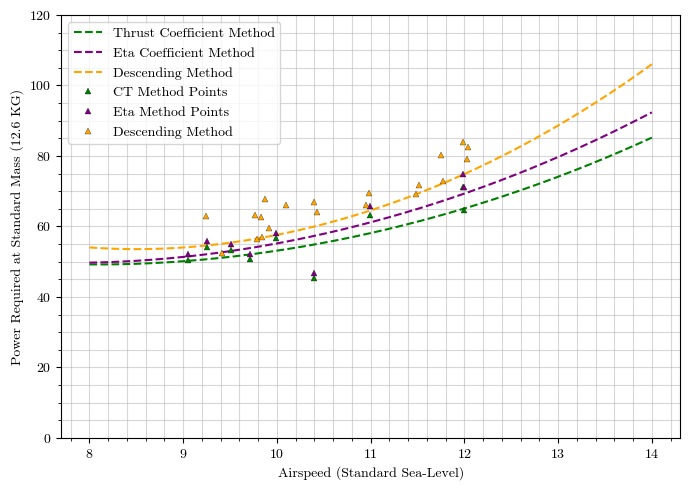

Plot already exists


In [19]:
# Plotting P_req vs EAS, Descending and Cruising Results
preq_EAS_raw_fitted = plt.figure(figsize=(7,5))
plt.plot(EAS, Peq_ct, label="Thrust Coefficient Method", color='green', linestyle='--', marker='')
plt.plot(EAS, Peq_eta, label="Eta Coefficient Method", color='purple', linestyle='--', marker='')
plt.plot(EAS, Peq_desc, label="Descending Method", color='orange', linestyle='--', marker='')
plt.plot(EAS_ave, CDct_ave * 0.5 * 1.225 * EAS_ave**3 * createv.area, linestyle='', marker='^', color='green', markeredgecolor=[0,0,0], label='CT Method Points')
plt.plot(EAS_ave, CDeta_ave * 0.5 * 1.225 * EAS_ave**3 * createv.area, linestyle='', marker='^', color='purple', markeredgecolor=[0,0,0], label='Eta Method Points')
plt.plot(EASdesc_ave, CDdesc_ave * 0.5 * 1.225 * EASdesc_ave**3 * createv.area, linestyle='', color='orange', marker='^', markeredgecolor=[0,0,0], label='Descending Method')
plt.xlabel("Airspeed (Standard Sea-Level)")
plt.ylabel("Power Required at Standard Mass (12.6 KG)")
plt.ylim([0, 120])
plt.legend()
plt.show()
main.save_figure(preq_EAS_raw_fitted, f'{preq_EAS_raw_fitted=}'.split('=')[0], figure_path)

### <a id='toc1_9_4_'></a>[Plotting C_L vs C_D, Descending and Cruising Results](#toc0_)

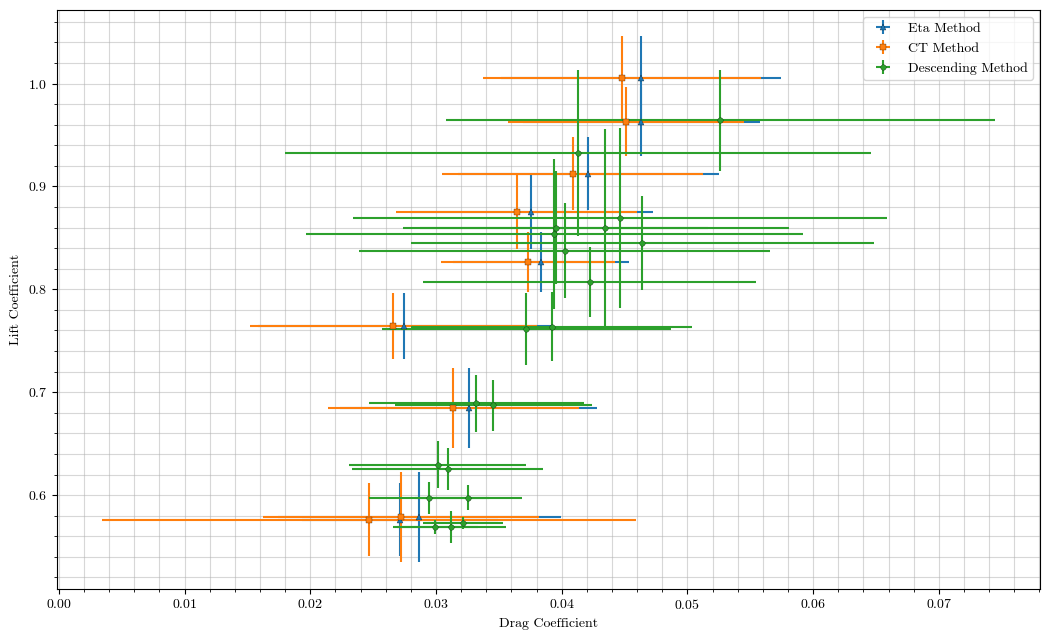

Plot already exists


In [20]:
# Plotting C_L vs C_D, Descending and Cruising Results
polar_rawerrorbar = plt.figure(figsize=(10.6,6.5), dpi=100)
plt.errorbar(CDeta_ave, CL_ave, xerr=CDeta_std, yerr=CL_std, fmt='^', label="Eta Method", markeredgecolor=[0,0,0])
plt.errorbar(CDct_ave, CL_ave, xerr=CDct_std, yerr=CL_std, fmt='s', label="CT Method", markeredgecolor=[0,0,0])
plt.errorbar(CDdesc_ave, CLdesc_ave, xerr=CDdesc_std, yerr=CLdesc_std, fmt='o', label = "Descending Method", markeredgecolor=[0,0,0])
plt.xlabel("Drag Coefficient")
plt.ylabel("Lift Coefficient")
plt.legend()
plt.show()

main.save_figure(polar_rawerrorbar, f'{polar_rawerrorbar=}'.split('=')[0], figure_path)

## <a id='toc1_10_'></a>[Time Indexed Plots](#toc0_)

### <a id='toc1_10_1_'></a>[Plotting Time Indexed data - Demanded vs True Airspeed \& Motor RPM](#toc0_)

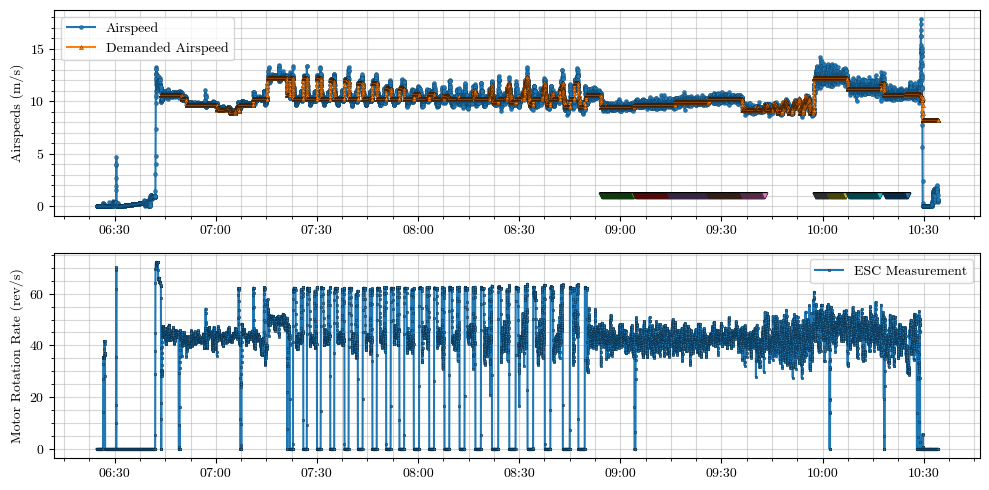

Plot already exists


In [21]:
# Plotting time indexed flight data
# Plotting true airspeed, with demanded airspeed
timeindexed_airspeed_motorrpm = plt.figure(figsize=(10,5))
ax1 = plt.subplot(2,1,1)
ax1.plot(df.index, v_tas, label="Airspeed", marker='o', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=0.1)
ax1.plot(df.index, v_dem, label="Demanded Airspeed", marker='^', markeredgecolor=[0,0,0], markersize=3)
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    ax1.plot(df.index[segment], np.ones(len(segment)), marker='v')
ax1.set_ylabel("Airspeeds (m/s)")
plt.legend()

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(df.index, n, label='ESC Measurement')
ax2.set_ylabel("Motor Rotation Rate (rev/s)")
plt.legend()

plt.show()
main.save_figure(timeindexed_airspeed_motorrpm, f'{timeindexed_airspeed_motorrpm=}'.split('=')[0], figure_path)

### <a id='toc1_10_2_'></a>[Plotting motor RPM over the selected time intervals](#toc0_)

Plot already exists


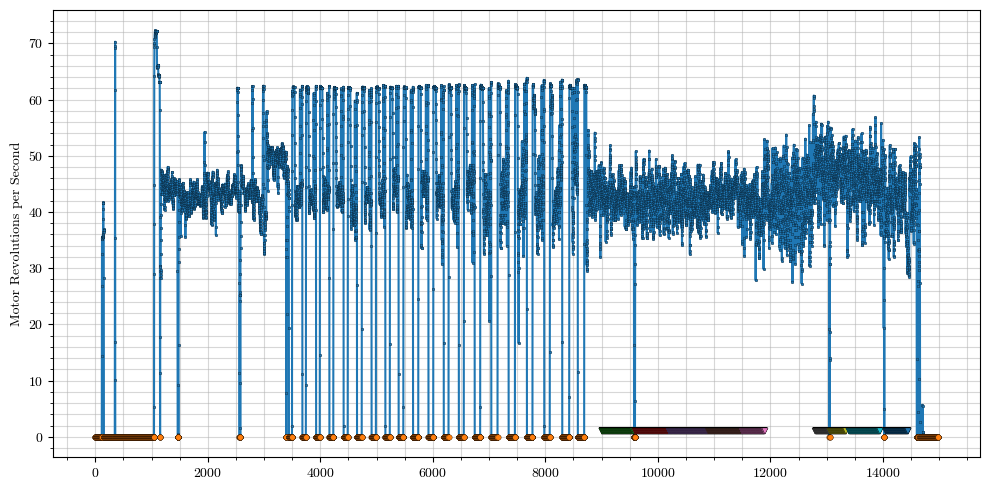

In [22]:
time_motorrpm_seghighlight = plt.figure(figsize=(10,5))
plt.plot(n)
plt.plot(np.transpose(np.where(n == 0)), n[n == 0], linestyle='None', marker='o', label='RPM=0')
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Motor Revolutions per Second")
main.save_figure(time_motorrpm_seghighlight, f'{time_motorrpm_seghighlight=}'.split('=')[0], figure_path)

Above plot showing motor rev/s vs time in seconds.  Orange points represent the times where rev/s reads zero.  Coloured V's represent the cruising segments that are being used for the data reduction.  This is used to visualize where we can get good data from, if n is zero during cruise this needs to be excluded.  

### <a id='toc1_10_3_'></a>[Plotting J to see where data needs exclusion](#toc0_)

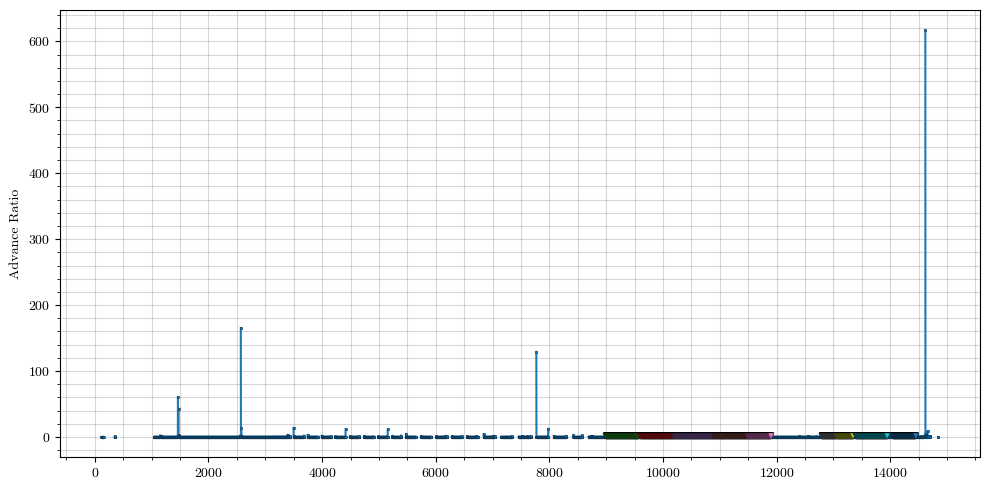

Plot already exists


In [23]:
time_advanceratio = plt.figure(figsize=(10,5))
plt.plot(J)
plt.plot(np.transpose(np.where(n == 0)), J[n == 0], linestyle='None', marker='o')
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Advance Ratio")
plt.show()
main.save_figure(time_advanceratio, f'{time_advanceratio=}'.split('=')[0], figure_path)

Data needs exclusion around 9570, since the J is going high due to the n going to zero.  
Data needs exclusion around 13045. 

### <a id='toc1_10_4_'></a>[Plotting System Efficiency](#toc0_)

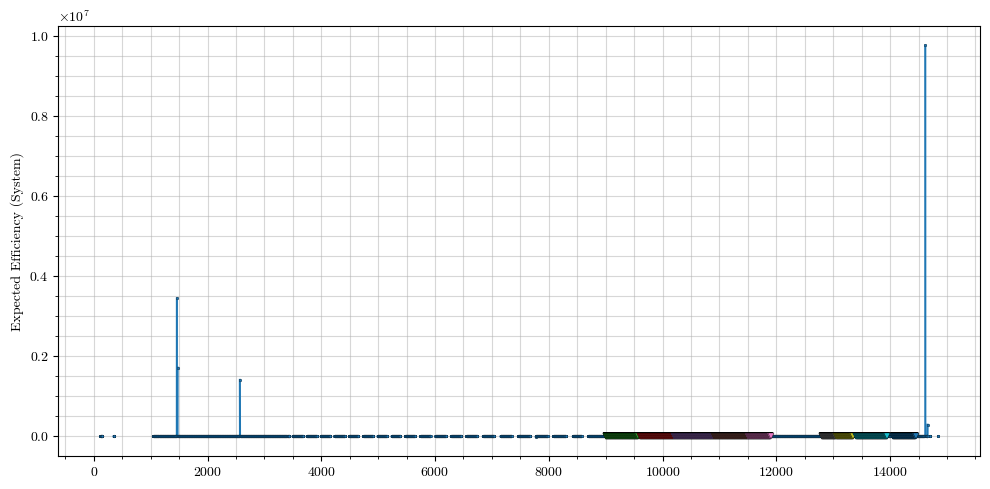

Plot already exists


In [24]:
time_sysefficiency = plt.figure(figsize=(10,5))
plt.plot(eff)
plt.plot(np.transpose(np.where(n == 0)), eff[n == 0], linestyle='None', marker='o')
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Expected Efficiency (System)")
plt.show()
main.save_figure(time_sysefficiency, f'{time_sysefficiency=}'.split('=')[0], figure_path)

Efficiency goes to infinity anytime the RPM goes low or to zero.  Same points identified earlier are a problem and need to be excluded for the $\eta$ method

### <a id='toc1_10_5_'></a>[Plotting Descent Rates, Zero RPM highlighted](#toc0_)

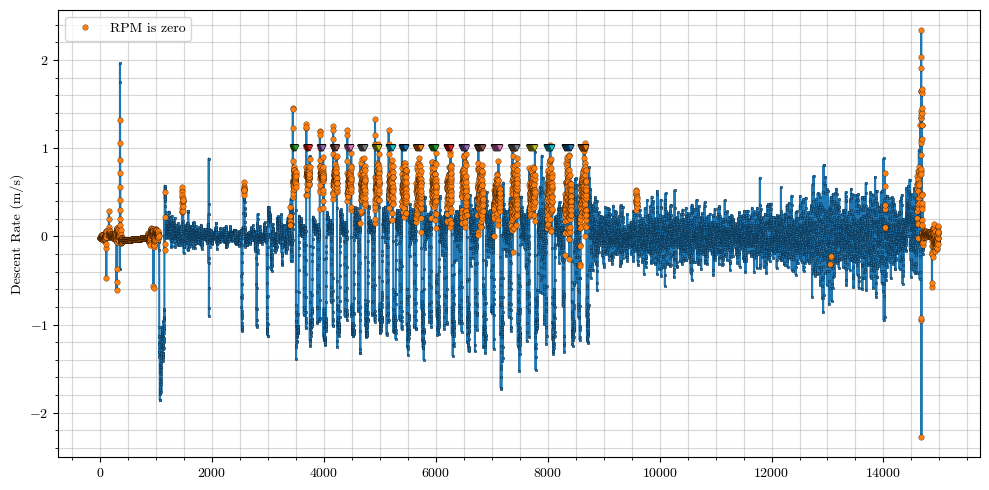

Plot already exists


In [25]:
time_descrate_seghighlight = plt.figure(figsize=(10,5))
plt.plot(Vd_tas)
plt.plot(np.transpose(np.where(n == 0)), Vd_tas[n == 0], linestyle='None', marker='o', label="RPM is zero")
for i in range(len(desc_mask)):
    segment = np.arange(desc_mask[i,0],desc_mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Descent Rate (m/s)")
plt.legend()
plt.show()
main.save_figure(time_descrate_seghighlight, f'{time_descrate_seghighlight=}'.split('=')[0], figure_path)

### <a id='toc1_10_6_'></a>[Pitch and Coefficient of Lift Time Plots](#toc0_)

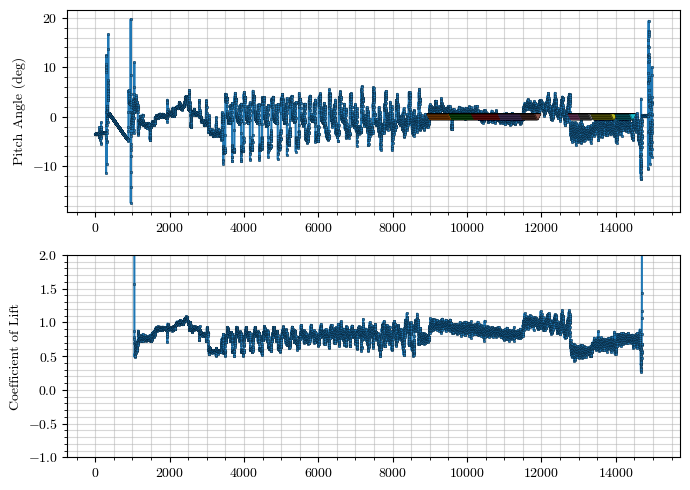

Plot already exists


In [26]:
# Pitch and $C_L$ vs. Time (s)
time_pitch_CL = plt.figure(figsize=(7,5))
ax1 = plt.subplot(2,1,1)
ax1.plot(np.rad2deg(pitch))
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    ax1.plot(segment, np.zeros(len(segment)), marker='v')
ax1.grid(True)
ax1.set_ylabel("Pitch Angle (deg)")

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(CL)
ax2.set_ylim([-1,2])
ax2.set_ylabel("Coefficient of Lift")

plt.show()
main.save_figure(time_pitch_CL, f'{time_pitch_CL=}'.split('=')[0], figure_path)

## <a id='toc1_11_'></a>[Exporting All Results](#toc0_)

In [27]:
# Exporting workspace
import dill
location = result_path + 'workspace.pkl'
dill.dump_session(location)

# Exporting polar data
# Packaging raw polars
rawpolar_eta = pd.DataFrame.from_dict({'CD': cd_total_eta, 'CL': cl_total_cruise})
rawpolar_ct = pd.DataFrame.from_dict({'CD': cd_total_ct, 'CL': cl_total_cruise})
rawpolar_desc = pd.DataFrame.from_dict({'CD': cd_total_desc, 'CL': cl_total_desc})
# Packaging averaged polars
avepolar_eta = pd.DataFrame.from_dict({'CD': cd_means_eta, 'CL': cl_means_cruise})
avepolar_ct = pd.DataFrame.from_dict({'CD': cd_means_ct, 'CL': cl_means_cruise})
avepolar_desc = pd.DataFrame.from_dict({'CD': cd_means_desc, 'CL': cl_means_desc})
# Packaging standard deviation polars
stdpolar_eta = pd.DataFrame.from_dict({'CD': cd_stds_eta, 'CL': cl_stds_cruise})
stdpolar_ct = pd.DataFrame.from_dict({'CD': cd_stds_ct, 'CL': cl_stds_cruise})
stdpolar_desc = pd.DataFrame.from_dict({'CD': cd_stds_desc, 'CL': cl_stds_desc})
# Packaging 95% CI polars
ci95polar_eta = pd.DataFrame.from_dict({'CD': cd_ci95_eta, 'CL': cl_ci95_cruise})
ci95polar_ct = pd.DataFrame.from_dict({'CD': cd_ci95_ct, 'CL': cl_ci95_cruise})
ci95polar_desc = pd.DataFrame.from_dict({'CD': cd_ci95_desc, 'CL': cl_ci95_desc})

# Constructing datatype to hold results
eta_cruise_fullresult = main.result(rawpolar_eta, avepolar_eta, stdpolar_eta, ci95polar_eta, polar_eta, createv)
ct_cruise_fullresult = main.result(rawpolar_ct, avepolar_ct, stdpolar_ct, ci95polar_ct, polar_ct, createv)
desc_fullresult = main.result(rawpolar_desc, avepolar_desc, stdpolar_desc, ci95polar_desc, polar_desc, createv)

eta_cruise_segresult = main.packaging_binresults(cl_total_cruise, cl_seg_means_eta, cl_seg_stds_eta, cl_seg_ci95s_eta, cd_total_eta, cd_seg_means_eta, cd_seg_stds_eta, cd_seg_ci95s_eta, polar_eta, createv)
ct_cruise_segresult = main.packaging_binresults(cl_total_cruise, cl_seg_means_ct, cl_seg_stds_ct, cl_seg_ci95s_ct, cd_total_ct, cd_seg_means_ct, cd_seg_stds_ct, cd_seg_ci95s_ct, polar_ct, createv)
desc_segresult = main.packaging_binresults(cl_total_desc, cl_seg_means_desc, cl_seg_stds_desc, cl_seg_ci95s_desc, cd_total_desc, cd_seg_means_desc, cd_seg_stds_desc, cd_seg_ci95s_desc, polar_desc, createv)

# Saving results to their pickles
pd.to_pickle(eta_cruise_fullresult, result_path+'eta_cruise_fullresult.pkl')
pd.to_pickle(ct_cruise_fullresult, result_path+'ct_cruise_fullresult.pkl')
pd.to_pickle(desc_fullresult, result_path+'desc_fullresult.pkl')

pd.to_pickle(eta_cruise_segresult, result_path+'eta_cruise_segresult.pkl')
pd.to_pickle(ct_cruise_segresult, result_path+'ct_cruise_segresult.pkl')
pd.to_pickle(desc_segresult, result_path+'desc_segresult.pkl')


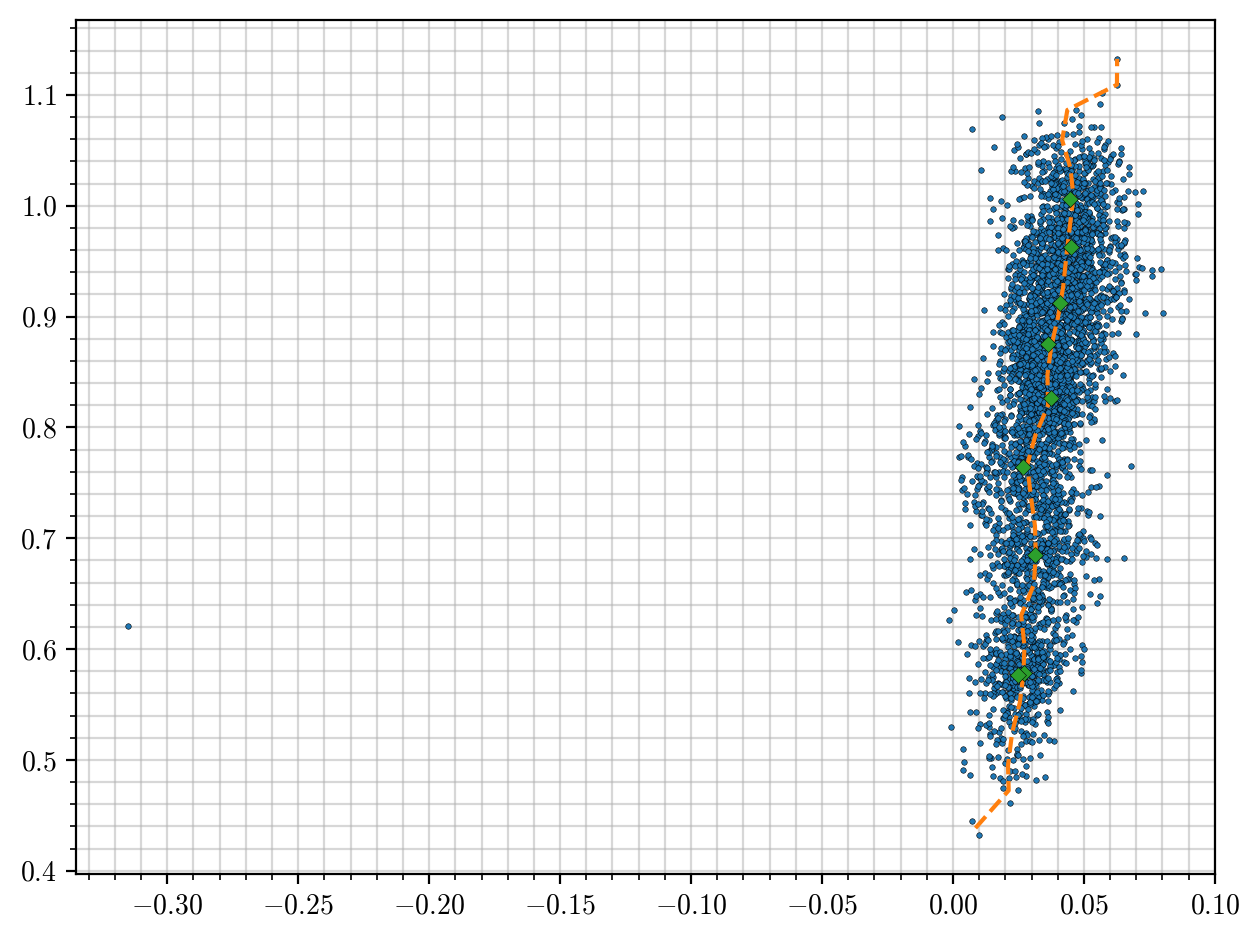

In [28]:
plt.figure(dpi=200)
plt.plot(ct_cruise_fullresult.raw_polar.CD, ct_cruise_fullresult.raw_polar.CL, linestyle='')
plt.plot(ct_cruise_fullresult.ave_polar.CD, ct_cruise_fullresult.ave_polar.CL, marker='', linestyle='--')

plt.plot(ct_cruise_segresult.ave_polar.CD, ct_cruise_segresult.ave_polar.CL, marker='D', linestyle='')
plt.show()

Example of how to use the constructed results for visualization

In [29]:
test = pd.read_pickle(result_path+'eta_cruise_fullresult.pkl')
test.fit_polar

array([0.0171718 , 0.69137088])

Working to load up the results using pandas read_pickle again!